In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from utils import *
from tests import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

# Logistic regression

## a9a

In [2]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness const: ", L)
print("Average smoothness const: ", average_L)
print("Worst smoothness const: ", worst_L)
print("Percentage of non-zeros: ", sparsity_A)

Number of functions:  32561 , dimension:  123
Smoothness const:  1.5719196992226603
Average smoothness const:  3.467276803535652
Worst smoothness const:  3.5
Percentage of non-zeros:  0.11275696922074716
CPU times: user 774 ms, sys: 115 ms, total: 889 ms
Wall time: 849 ms


### Find the solution (Run this code only once)

In [3]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [4]:
%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-18)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          123     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05140D+01    |proj g|=  7.36278D-01

At iterate    1    f=  1.36822D+00    |proj g|=  4.86435D-01

At iterate    2    f=  9.17965D-01    |proj g|=  1.82142D-01

At iterate    3    f=  6.58786D-01    |proj g|=  1.24432D-01

At iterate    4    f=  5.30723D-01    |proj g|=  4.09953D-02

At iterate    5    f=  4.97935D-01    |proj g|=  4.34748D-02

At iterate    6    f=  4.52326D-01    |proj g|=  4.46673D-02

At iterate    7    f=  4.05799D-01    |proj g|=  2.88194D-02

At iterate    8    f=  3.65373D-01    |proj g|=  1.67005D-02

At iterate    9    f=  3.44960D-01    |proj g|=  1.14034D-02

At iterate   10    f=  3.34135D-01    |proj g|=  1.17691D-02

At iterate   11    f=  3.31434D-01    |proj g|=  4.64799D-03

At iterate   12    f=  3.29510D-01    |proj g|=  3.85815D-03

At iterate   13    f=  3.2

 This problem is unconstrained.



At iterate   18    f=  3.25852D-01    |proj g|=  1.17323D-03

At iterate   19    f=  3.25525D-01    |proj g|=  1.75403D-03

At iterate   20    f=  3.25122D-01    |proj g|=  1.85300D-03

At iterate   21    f=  3.24933D-01    |proj g|=  2.24904D-03

At iterate   22    f=  3.24764D-01    |proj g|=  1.07034D-03

At iterate   23    f=  3.24645D-01    |proj g|=  1.10733D-03

At iterate   24    f=  3.24506D-01    |proj g|=  3.88614D-04

At iterate   25    f=  3.24414D-01    |proj g|=  6.44312D-04

At iterate   26    f=  3.24381D-01    |proj g|=  1.60412D-03

At iterate   27    f=  3.24312D-01    |proj g|=  9.25345D-04

At iterate   28    f=  3.24261D-01    |proj g|=  4.51013D-04

At iterate   29    f=  3.24197D-01    |proj g|=  9.87819D-04

At iterate   30    f=  3.24115D-01    |proj g|=  1.12029D-03

At iterate   31    f=  3.24067D-01    |proj g|=  7.66672D-04

At iterate   32    f=  3.24019D-01    |proj g|=  3.04702D-04

At iterate   33    f=  3.23991D-01    |proj g|=  3.14356D-04

At iter

In [5]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

### Noise distribution

In [6]:
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

In [7]:
norm(logreg_grad(x_star, [denseA, y, 0, False]))

1.2868551696160458e-08

In [8]:
%%time
x = deepcopy(x_star)
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

CPU times: user 1.99 s, sys: 127 ms, total: 2.12 s
Wall time: 1.99 s


In [9]:
np.sort(grad_deviations)

array([1.28707828e-08, 1.28726042e-08, 1.28739218e-08, ...,
       3.73398986e+00, 3.73788662e+00, 3.73991573e+00])

In [10]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean((grad_deviations - mu)**2))
print(mu)
print(sigma)

0.769314802465482
0.9215192707426804


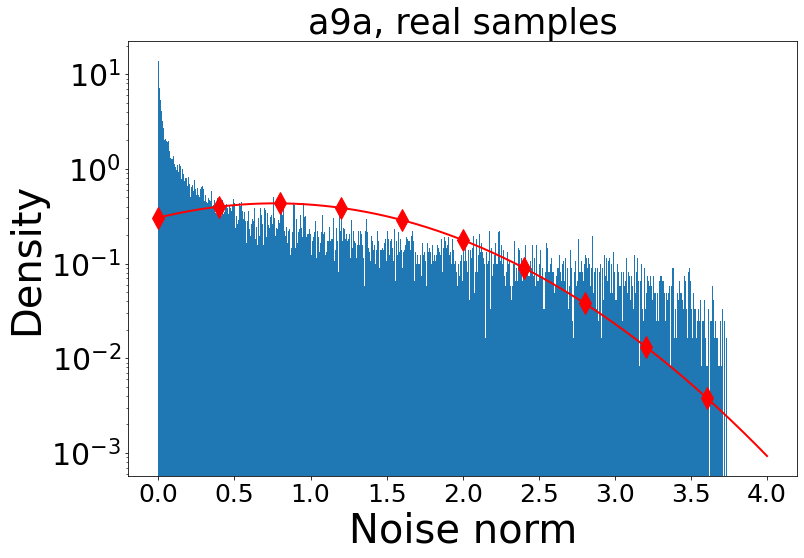

In [11]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=25)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=1000, density=1, log=True)
temp2 = np.linspace(0, 4.0, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_real.pdf", bbox_inches='tight')

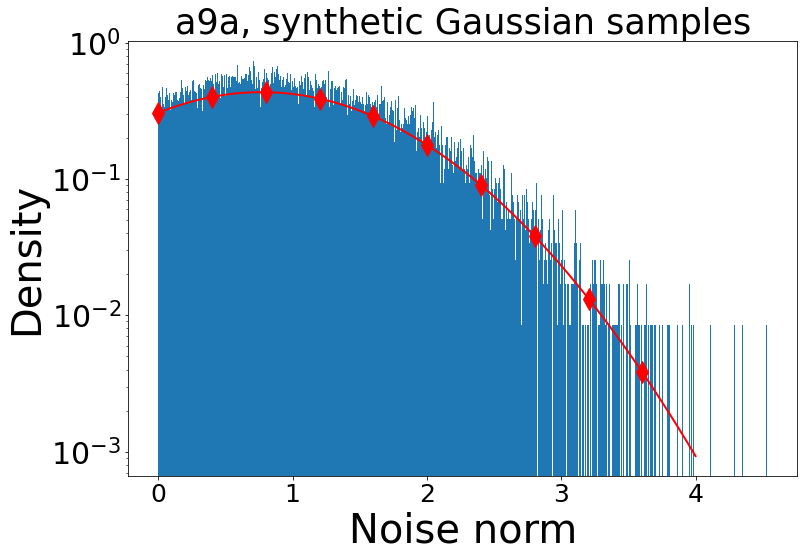

In [12]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=25)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=1000, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
# t, bins, patches = plt.hist(np.where(sample>0, sample, 0), bins=50, density=1, log=True)
temp2 = np.linspace(0, 4.0, 1000)
# plt.plot(temp2, norm_d.pdf(temp2, mu, sigma))
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_synthetic.pdf", bbox_inches='tight')

### Tests

In [13]:
shift_param = 1.0
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = 0
l1 = 0
batch_size = 100
gamma = 1.0/(L+l2)
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)
lambd = 2*np.sqrt(2)*(L+l2)*norm(x_star-x_init)
lambd_schedule = [lambd, 1000, 0.9]
S = 100
save_info_period = 100
beta = 0.001
N = int(S*m/batch_size)
a = ((np.log(4*N/beta)) ** 2)
print("a = ", a)

B = norm(x_star-x_init) / (np.log(4*N/beta))
print("B = ", B)

sparse_full = False
sparse_stoch = False

a =  349.12624184438624
B =  0.5935554663414726


In [14]:
print("gamma = ", gamma)

gamma =  0.6361648120412997


In [15]:
print("Functional suboptimality: ", logreg_loss(x_init, [denseA,y,l2,False,0])-f_star)

Functional suboptimality:  7.7291337686679915


In [16]:
print(lambd)

49.30919423547084


### SSTM

In [17]:
%%time

res = sstm(filename=filename, x_init=x_init, A=A, y=y, a=1.0,
             L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)

CPU times: user 13 s, sys: 12.9 s, total: 25.9 s
Wall time: 6.82 s


In [19]:
%%time

res = clipped_sstm(filename=filename, x_init=x_init, A=A, y=y, a=1.0,
             B=B, L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
#i += 1
#print("Комбинация ", i)
##print(a_tun_const, B_tun_const)
#print("Найденное значение: ", res['func_vals'][-1]+f_star)

Комбинация  32561
Найденное значение:  0.3317881604596594
CPU times: user 13.9 s, sys: 15.4 s, total: 29.3 s
Wall time: 7.74 s


### SGD and clipped-SGD

In [20]:
%%time
lambd_schedule = [lambd*0.1, 5, 0.5]
res = clipped_sgd_const_stepsize_decr_clip(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     lambd_schedule=lambd_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 13.9 s, sys: 14.9 s, total: 28.8 s
Wall time: 7.84 s


In [21]:
%%time
res = clipped_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma*0.5,
     lambd=lambd*0.0005, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 14.3 s, sys: 14.8 s, total: 29.1 s
Wall time: 7.79 s


In [22]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma*0.5,
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 12.8 s, sys: 12.5 s, total: 25.3 s
Wall time: 6.65 s


FileNotFoundError: [Errno 2] No such file or directory: 'dump/a9a_x_star_shifted_by_all_ones_shift_1.0_clipped-SSTM_a_1.0_B_0.029677773317073632_L_1.5719196992226603_l2_0_num_of_epochs_100_batch_size_100.txt'

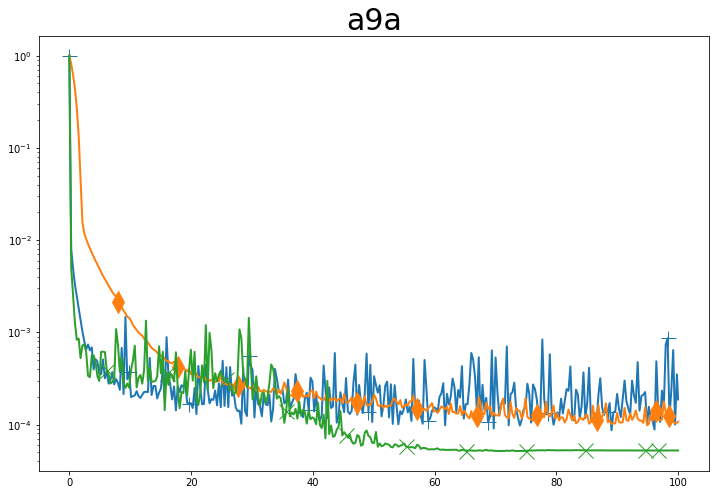

In [23]:
methods = [
         ['SGD_const_stepsize', [gamma*0.5, l2, l1, S, batch_size], 
           'SGD', None],
         ['clipped-SGD_const_stepsize', [gamma*0.5, lambd*0.0005, l2, l1, S, batch_size], 
           'clipped-SGD', None],
         ['clipped-SGD_const_stepsize_decr_clip', [gamma, 
                                                   lambd_schedule,
                                                   l2, l1, S, batch_size], 
           'd-clipped-SGD', None],
           ['clipped-SSTM', [1.0, B*0.05, L+l2, l2, S, batch_size], 
           'clipped-SSTM', None],
         ['SSTM', [1.0, L+l2, l2, S, batch_size], 
           'SSTM', None],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 25
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_test_test.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [24]:
res = read_results_from_file(filename, 'SGD_const_stepsize', [gamma, l2, l1, S, batch_size])

FileNotFoundError: [Errno 2] No such file or directory: 'dump/a9a_x_star_shifted_by_all_ones_shift_1.0_SGD_const_stepsize_gamma_0.6361648120412997_l2_0_l1_0_num_of_epochs_100_batch_size_100.txt'

In [25]:
%%time
x = deepcopy(res['last_iter'])
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

CPU times: user 2.26 s, sys: 138 ms, total: 2.39 s
Wall time: 2.2 s


In [26]:
print(norm(full_grad))

0.03291000669944987


In [27]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean((grad_deviations - mu)**2))
print(mu)
print(sigma)

0.7745422196943098
0.9203869528263038


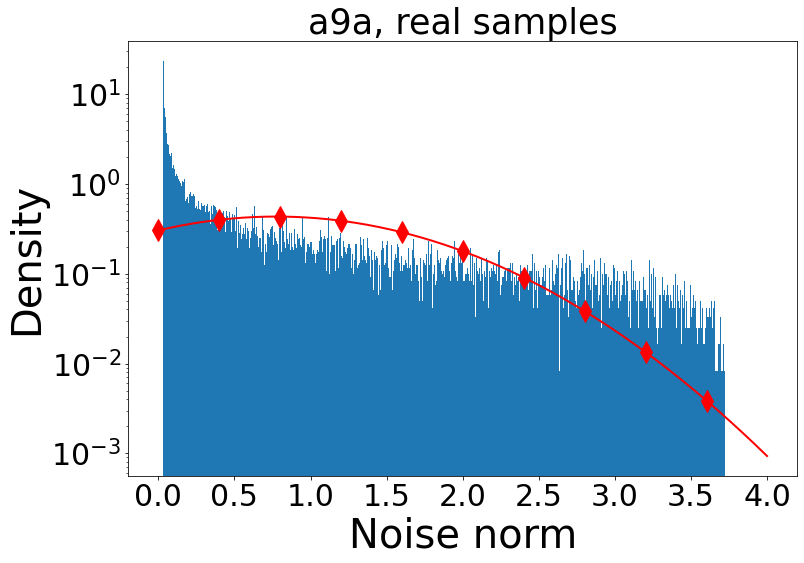

In [28]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=1000, density=1, log=True)
temp2 = np.linspace(0, 4, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_sgd_last_point_big_step.pdf", bbox_inches='tight')

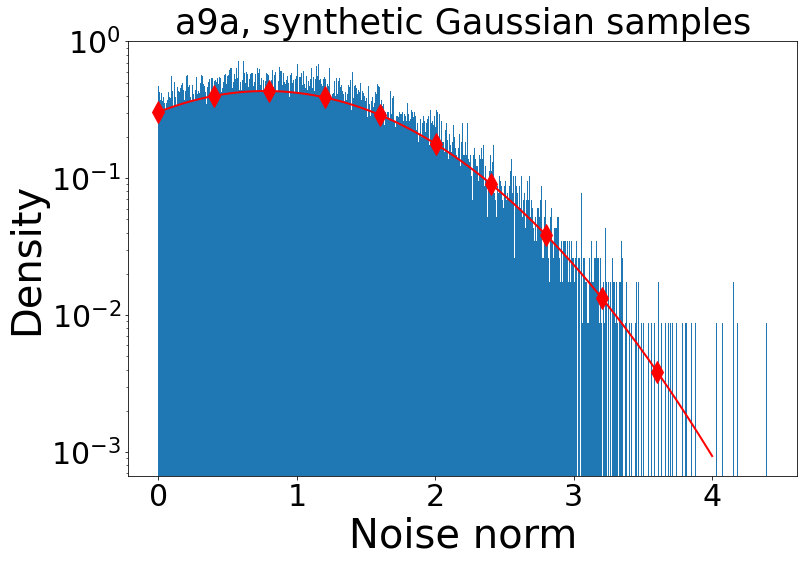

In [29]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=1000, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
# t, bins, patches = plt.hist(np.where(sample>0, sample, 0), bins=50, density=1, log=True)
temp2 = np.linspace(0, 4, 1000)
# plt.plot(temp2, norm_d.pdf(temp2, mu, sigma))
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_synthetic_sgd_last_iter_big_step.pdf", bbox_inches='tight')